## **Mountain Car Problem: Introduction**

The mountain car problem is a classical control problem that illustrates the dynamics of a car moving on a profile. This problem is influenced by gravity, the profile's inclination, and an applied acceleration input, as depicted in the figure below. Our primary objective is to design a control policy using various methods (e.g. LQR, MPC, and RL) to drive the car from an initial state $x_0$ to a predefined terminal state $x_T$, all while being subject to constraints.

![Figure 1: Illustration of a mountain car problem](../figure/MountainCarIllustration.png)

## **Variations of the Mountain Car Problem**

The mountain car problem can be set up in different ways to study various aspects of this control problem and can be divided into the following categories:


### 1. **Type of Task**

- **Terminal State Reaching**: The classic setting where the car must reach a goal state (e.g., the hilltop) as quickly or efficiently as possible.
- **Energy Minimization**: The controller aims to reach the goal while minimizing the total control effort.
- **Stabilization**: The goal is to stabilize the car at the top of the hill or a designated equilibrium point **(the focus of this Jupyter Notebook series)**.
- **Trajectory Tracking**: The car is required to follow a predefined trajectory over time, often under time or energy constraints.
- **Time-Optimal Control**: The focus is on minimizing the number of time steps to reach the goal.


### 2. **Type of Dynamics**

- **Linear Dynamics**: Used for simplified analysis or as a local approximation near equilibrium points. For example the car moving along a flat ground or a slope with constant inclination angle.
- **Nonlinear Dynamics**: Captures the true behavior of the system, especially due to gravitational effects and nonlinear terrain profiles. Introduces spatially varying accelerations, making the problem significantly harder but also more realistic.


### 3. **Type of State and Input**

- **Continuous State**: The position and velocity of the car are typically modeled as continuous variables.
- **Discrete State**: Less common, but discretized versions are used in tabular reinforcement learning settings. A more general example of discrete state space is the Traveling Salesman Problem (TSP).

- **Continuous Input**: The control input (eg. acceleration in mountain car problem) is a real-valued force applied to the car.
- **Discrete Input**: The input is limited to a small set of actions, such as in bang-bang control where the action is either full throttle forward, full throttle backward, or zero.

- **Unconstrained State / Input**: Used in theoretical analysis or to simplify optimization.
- **Constrained State / Input**: Many setups limit the state / control magnitude to reflect physical or actuator limits.


These variations enable researchers and practitioners to explore a broad spectrum of control strategies, from classical methods (e.g., PID, LQR) to modern techniques (e.g., MPC, reinforcement learning), under diverse dynamics and objectives.



----


### **Chapter 1: Problem Definition and Dynamic Programming**


In the first chapter, we will introduce the mountain car problem and demonstrate how to implement a Dynamic Progamming (DP)-based controller. We begin with implementing the mountain car environment (e.g., defining the slope and constraints), followed by defining the system dynamics and implementing the controller based on DP. The contents are summarized in the table below.  

| Column 1 | Column 2 | Column 3 |
|----------|----------|----------|
|   A1     |   B1     |   C1     |
|   A2     |   B2     |   C2     |
|   A3     |   B3     |   C3     |

First, we need to set up our Python environment and import relevant packages.

In [1]:
# Import all related classes from the predefined repo
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca

----

#### **Part (a): Defining the Mountain Car Environment**


In this part, we set up the environment for the mountain car problem. The environment consists of defining the terrain profile, mapping the terrain to inclination angles, and specifying task parameters for the controller. The steps include creating a mathematical representation of the terrain, deriving the relationship between the slope and inclination angle, and finally specifying parameters such as the initial state, terminal state, and constraints to uniquely define a control task.


**Step 1: The Mountain Profile $h(p)$**

The mountain profile describes the height $h$ with reference to horizontal position $p$. As mentioned above, there are different choices for the mountain profile in the mountain car problem. Here we specifically designed 4 cases (as shown in the figure below), where we have 2 linear cases and 2 nonlinear cases:

 - Case 1: zero slope (linear system);
 
 - Case 2: constant slope (linear system);
 
 - Case 3: varying slope (nonlinear system);
 
 - Case 4: varying slope and underactuated system (nonlinear system).

*Note that: The underactuated case refers to a scenario where the input is limited and may be insufficient to generate enough force to climb uphill directly.*

![Figure 2: Different mountain profile choices](../figure/MountainProfileCases.png)

The analytical expressions of the profiles are:

 - Case 1: $\quad h(p) = c,$

 - Case 2: $\quad h(p) = \frac{\pi}{18} \cdot p,$

 - Case 3: $\quad h(p) = \begin{cases} 1, & p \in (\frac{\pi}{6}, \infty) \\ k \cdot cos(3 (p-\frac{\pi}{2})), &p \in [-\frac{\pi}{6}, \frac{\pi}{6}] \\ -1, & p \in (-\infty, -\frac{\pi}{6}) \end{cases}$

 - Case 4: $\quad h(p) = \begin{cases} k \cdot sin(3 p), & p \in [- \frac{\pi}{2}, \frac{\pi}{6}] \\ 1, & p \in (-\infty, -\frac{\pi}{2}) \cup (\frac{\pi}{6}, \infty) \end{cases}$


In [2]:
# Define the profile of mountain h(p)
#  - argument: 1) p: CasAdi symbolic expression `p`
#              2) case: integer value to choose the mountain's profile
#  - return: value of `h`

def h(p, case):
    
    # zero slope
    if case == 1:
        h = 0
   
    # constant slope
    elif case == 2: 
        h = (ca.pi * p) / 18
    
    # varying slope
    elif case == 3: 
        h_center = ca.cos(3 * (p - ca.pi/2))
        h_flat_left = 1
        h_flat_right = -1

        condition_left = p <= -ca.pi/6
        condition_right = p >= ca.pi/6

        h = ca.if_else(condition_left, h_flat_left, ca.if_else(condition_right, h_flat_right, h_center))

    # varying slope for underactated case
    elif case == 4: 
        h_center = ca.sin(3 * p)
        h_flat = 1

        condition_left = p <= -ca.pi/2
        condition_right = p >= ca.pi/6

        h = ca.if_else(condition_left, h_flat, ca.if_else(condition_right, h_flat, h_center))

    return h


**Step 2: Mapping From Profile $h(p)$ to Inclination Angle $\theta(p)$**

- Transformation function from $h$ to $\theta$:

   \begin{align*}
     \theta = \arctan\left(\frac{dh}{dp}\right)
   \end{align*}

- Hint: 

  1. Using the CasAdi symbolic expression as the input, we can directly solve the gradient $\frac{dh}{dp}$ with method `ca.jacobian(h, p)`; 

  2. The angle $\theta$ is defined in radian;  

- Notice: If the function $h(p)$ is defined numerically rather than symbolically, we can use **numerical differentiation** to approximate $\frac{dh}{dp}$.

In [3]:
# Calculate inclination angle theta(p) based on terrain profile h(p)
#  - argument: CasAdi symbolic expression `h_func`
#  - return: CasAdi symbolic expression `theta(p)`

def symbolic_theta(h_func):

    p = ca.SX.sym("p")

    h = h_func(p) 
    dh_dp = ca.jacobian(h, p)
    theta = ca.atan(dh_dp)
    
    return ca.Function("theta", [p], [theta])


**Step 3: Environment Parameters and Control Task**

- Task: start from given initial position $p_0$, to reach a given target position $p_T$ (Stabilization)

- You may use the pre-defined method `test_env()` to check the slope $h(p)$ and and the inclination angle $\theta(p)$.



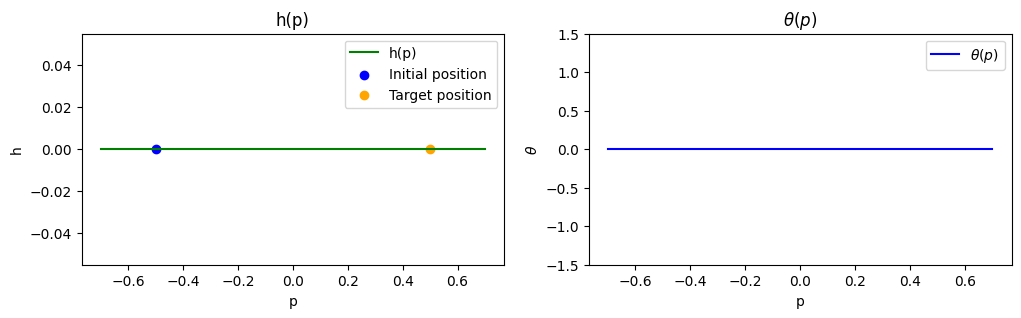

In [4]:
case = 1 # 1 / 2 / 3 / 4

# Define the initial / target state
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.5
target_velocity = 0.0

# Define the state / input constraints
state_lbs = None
state_ubs = None
input_lbs = -4
input_ubs = 4

# Instantiate class 'Env'
#  - argument: 1) `case`: n in [1, 2], type: int
#              2) `initial state`: x_0 = [p_0, v_0] ^ T, type: np.array
#              3) `terminal state`: x_T = [p_T, v_T] ^ T, type: np.array
#              4) `h`: mountain profile w.r.t. cases (defined in step 1), type: function
#              5) `symbolic_theta`: CasADi symbolic expression of inclination angle (defined in step 2), type: ca.Function
#              6) constraints on states and inputs:
#                  - `state_lbs`: lower limit of state, type: np.array or None (if no related limit)
#                  - `state_ubs`: upper limit of state, type: np.array or None (if no related limit)
#                  - `input_lbs`: lower limit of input, type: np.array or None (if no related limit)
#                  - `input_ubs`: upper limit of input, type: float or None (if no related limit)

env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]), h, symbolic_theta, 
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)

# Results visualisation
env.test_env() #  shape of slope (left side) and theta curve (right side) 

----

#### **Part (b): System Dynamics**


In the previous section, we defined the mountain car environment, including the terrain profile and the mapping from the profile to the inclination angle. In this section, we define a class that describes the system dynamics of the mountain car on this mountain profile. This includes specifying the state and input vectors, constructing the dynamics equations using symbolic computation in CasADi, and linearization and discretization.

Consider the following set of parameter that describe the motion of the mountain car:

   - the horizontal position of the car $p$;
   - the horizontal velocity of the car $v=\dot{p}$;
   - the applied acceleration input $a$, excluding gravitational and slope-induced effects.

The following figure illustrates the free-body diagram of the mountain car, where its motion is influenced by the applied acceleration $a$, gravitational forces, and the normal force.

![Figure 3: FBD of mountaincar problem](../figure/MountaincarFBD.png)

By applying Newton's second law along the horizontal direction, the equation of motion can be expressed as:

$$m\ddot{p} = (ma-mg\sin(\theta))\cos(\theta),$$


where $m$ represents the mass of the car, $g$ is the acceleration due to gravity, and $\theta$ denotes the inclination angle of the slope. This equation can be reformulated into a system of first-order differential equations as follows:
$$
  \left\{
  \begin{aligned}
  \dot{p} &= v, \\
  \dot{v} &= -g\sin(\theta)\cos(\theta)+a\cos(\theta),
  \end{aligned}
  \right.
$$

To facilitate analysis and control design, the system dynamics can be expressed in a state-space representation:

   - state vector $\boldsymbol{x} = [p, v]^T$
   - input vector $u = a$
   - system dynamics:
   \begin{align*}
     \begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} v \\ - g \sin(\theta) \cos(\theta) \end{bmatrix} + \begin{bmatrix} 0 \\ \cos(\theta)  \end{bmatrix} a
   \end{align*}


**Step 1: Setup the Mountain Car Dynamics**

- Hints about defining CasADi symbolic expression: 

  1. The variables used for symbolic computation should be declared in datatype `ca.SX` or `ca.MX`;

  2. To combine several variables into a vector, use `ca.vertcat(a, b, ...)`;

  3. To define a CasADi function, use `ca.Function("function_name", [input1, input2, ...], [output])`;
  
  4. To call a CasADi function, use `function_name(input1, input2, ...))`;

- Supplementary materials:
  
  1. Introduction to symbolic modeling in CasADi: https://web.casadi.org/docs/#document-symbolic
  
  2. CasADi's Python API: https://web.casadi.org/python-api/
  

In [5]:
# Define dynamics of 1d mountain car
#  - arguments: `theta_function`: CasADi symbolic function of inclination angle `theta_function`, type: ca.Function
#  - return: `dynamics_function`: CasADi symbolic function of dynamics, type: ca.Function

def setup_dynamics(theta_function):

    p = ca.SX.sym("p")
    v = ca.SX.sym("v")
    a = ca.SX.sym("a")
    Gravity = 9.81

    theta = theta_function(p)

    # Expression of dynamics
    dpdt = v
    dvdt = a * ca.cos(theta) - Gravity * ca.sin(theta) * ca.cos(theta)
    
    state = ca.vertcat(p, v)
    input = ca.vertcat(a)
    rhs = ca.vertcat(dpdt, dvdt)

    return ca.Function("dynamics_function", [state, input], [rhs])



**Step 2: Linearizing the System Dynamics**

The derived equations of motion above are typically written in the form of $\dot{\boldsymbol{x}} = \boldsymbol{f} (\boldsymbol{x}, \boldsymbol{u})$, where $\boldsymbol{x}$ is the state, $\boldsymbol{u}$ is the input, and $\boldsymbol{f}: n \times m \to n$ denote the mapping from state and input to the derivatives of the state. Generally speaking, the function $\boldsymbol{f}$ is nonlinear, which means the evolution of the system dynamics cannot be captured by simple linear algebraic operations such as matrix multiplication. This significantly increases the complexity of solving the problem. To simplify the problem, especially in the context of local analysis or model-based control (e.g., LQR, MPC), it is a common practice to **linearize** the nonlinear dynamics around a given **operating point**.


Assume we are interested in the behavior of the system near some nominal point $(\boldsymbol{x}_0, \boldsymbol{u}_0)$. We perform a **first-order Taylor expansion** of $\boldsymbol{f}(\boldsymbol{x}, \boldsymbol{u})$ around this point:  

$$
\boldsymbol{f}(\boldsymbol{x}, \boldsymbol{u}) \approx \boldsymbol{f}(\boldsymbol{x}_0, \boldsymbol{u}_0) + 
\left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)} 
(\boldsymbol{x} - \boldsymbol{x}_0) +
\left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{u}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)} 
(\boldsymbol{u} - \boldsymbol{u}_0).
$$

We define the **perturbation variables** as:  

$$
\delta \boldsymbol{x} = \boldsymbol{x} - \boldsymbol{x}_0, \quad
\delta \boldsymbol{u} = \boldsymbol{u} - \boldsymbol{u}_0.
$$

Substitute them into the expansion:  

$$
\dot{\boldsymbol{x}} \approx \boldsymbol{f}(\boldsymbol{x}_0, \boldsymbol{u}_0) + 
\left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)} \delta \boldsymbol{x} + \left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{u}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)} \delta \boldsymbol{u}.
$$

Since $\dot{\boldsymbol{x}}_0 = \boldsymbol{f}(\boldsymbol{x}_0, \boldsymbol{u}_0)$ and $\dot{\delta \boldsymbol{x}} = \dot{\boldsymbol{x}} - \dot{\boldsymbol{x}}_0$, the **linearized system dynamics** around the nominal point become:  

$$
\dot{\delta \boldsymbol{x}} = \boldsymbol{A} \delta \boldsymbol{x} + \boldsymbol{B} \delta \boldsymbol{u},
$$

with state matrix $\boldsymbol{A}$ and input matrix $\boldsymbol{B}$ defined as:  

$$
\boldsymbol{A} = \left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)}, \quad
\boldsymbol{B} = \left. \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{u}} \right|_{(\boldsymbol{x}_0, \boldsymbol{u}_0)}.
$$

This linearized model accurately approximates the original nonlinear system **locally**, i.e., within a small neighborhood around the point $(\boldsymbol{x}_0, \boldsymbol{u}_0)$, and forms the basis for many powerful linear control design techniques.



In [6]:
def linearization_external(
    self,
    current_state: np.ndarray, 
    current_input: np.ndarray, 
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute symbolic Jacobians A(x,u) & B(x,u) and state / input matrix A & B of the system dynamics.
    """

    f = self.dynamics_function(self.states, self.inputs)
    A_sym = ca.jacobian(f, self.states)
    B_sym = ca.jacobian(f, self.inputs)

    self.A_func = ca.Function("A_func", [self.states, self.inputs], [A_sym])
    self.B_func = ca.Function("B_func", [self.states, self.inputs], [B_sym])

    A_c = np.array(self.A_func(current_state, current_input))
    B_c = np.array(self.B_func(current_state, current_input))

    return A_c, B_c

**Step 3: Discretization of the system dynamics**

After linearizing the continuous-time nonlinear system, we obtain a system in the form:

$$
\dot{\boldsymbol{x}}(t) = \boldsymbol{A} \boldsymbol{x}(t) + \boldsymbol{B} \boldsymbol{u}(t).
$$

Due to the inherently discrete nature of modern computing and control systems, our goal is to convert this into a discrete-time system of the form:

$$
\boldsymbol{x}_{k+1} = \boldsymbol{A_d} \boldsymbol{x}_k + \boldsymbol{B_d} \boldsymbol{u}_k.
$$

We assume that during each sampling interval $[k\Delta t, (k+1)\Delta t)$, the input $\boldsymbol{u}(t)$ remains **constant**. This as also known as the **Zero-order hold (ZOH)**, which is a mathematical model used to describe signal reconstruction in traditional digital-to-analog converters (DACs). The exact discretization under ZOH is:

$$
\boldsymbol{A_d} = e^{\boldsymbol{A} \Delta t}, \quad
\boldsymbol{B_d} = \left( \int_0^{\Delta t} e^{\boldsymbol{A} \tau} d\tau \right) \boldsymbol{B}.
$$

Instead of computing $\boldsymbol{B_d}$ using numerical integration, we can use the **augmented matrix exponential** trick:

$$
\exp \left( \Delta t 
\begin{bmatrix}
\boldsymbol{A} & \boldsymbol{B} \\
0 & 0
\end{bmatrix}
\right)
=
\begin{bmatrix}
\boldsymbol{A_d} & \boldsymbol{B_d} \\
0 & I
\end{bmatrix}.
$$

*Note that: this process can also be performed automatically using `scipy.signal.cont2discrete((A, B, C, D), dt)`*

In [7]:
def discretization_external(
    self,
    A_c: np.ndarray,
    B_c: np.ndarray,
    dt: float
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Discretize continuous-time linear system x_dot = A_c x + B_c u
    using matrix exponential method (Zero-Order Hold).

    Returns:
        A_d, B_d: Discrete-time system matrices
    """

    # Construct augmented matrix
    aug_matrix = np.zeros((self.dim_states + self.dim_inputs, self.dim_states + self.dim_inputs))
    aug_matrix[:self.dim_states, :self.dim_states] = A_c
    aug_matrix[:self.dim_states, self.dim_states:] = B_c

    # Compute matrix exponential
    exp_matrix = scipy.linalg.expm(aug_matrix * dt)

    # Extract A_d and B_d
    A_d = exp_matrix[:self.dim_states, :self.dim_states]
    B_d = exp_matrix[:self.dim_states, self.dim_states:]

    return A_d, B_d

**Step 4: Arguments for Class 'Dynamics' and Instantiate the Class**
  
- Steps: 

  1) Bind the defined linearization and discretization function to class `Dynamics`, it will be automatically called by other methods;

  2) Specify the arguments and instantiate the class `Dynamics`;

In [8]:
# Define the states and input as symbolic variables
state_names = ["p", "v"]
input_names = ["a"]

# Bind the defined algorithm to the corresponding class, will be automatically called by other methods
Dynamics.linearization = linearization_external
Dynamics.discretization = discretization_external

# Instantiate class 'Dynamics'
#  - arguments: 1) `env`: object of class `Env`, type: Env
#              2) `state_names`: names of state variables, type: list[str]
#              3) `input_names`: names of input variables, type: list[str]
#              4) `setup_dynamics`: setup function for system dynamics defined in the last step, type: function

dynamics = Dynamics(env, state_names, input_names, setup_dynamics)

----

#### **Part (C): Implement the Dynamic Programming-based Controller**

**Problem Formulation:**

$$
J_k(\boldsymbol{x_k}) = \min_{u_{k|k}, \ldots, u_{k+N-1|k}} 
\sum_{i=0}^{N-1} u_{k+i|k} ^T \boldsymbol{R} u_{k+i|k}
+ \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)^T \boldsymbol{Q_f} \left( \boldsymbol{x_{k+N|k}} - \boldsymbol{x_T} \right)
$$

subject to:

$$
\boldsymbol{x_{k+i+1|k}} = \boldsymbol{A_{d}} \boldsymbol{x_{k+i|k}} + \boldsymbol{B_{d}}u_{k+i|k}, \quad \forall i \in \{0, \ldots, N-1\}
$$

$$
\boldsymbol{x_{1,k|k}} = \boldsymbol{x_{1,k}}, \quad \boldsymbol{x_{2,k|k}} = \boldsymbol{x_{2,k}}
$$

**Step 1: Stage Cost and Terminal Cost**  

Define the function of stage cost $l(\boldsymbol{x}, u)$ and terminal cost $g(\boldsymbol{x})$, which will be called by the solver (here SLSQP) in the following DP algorithm.

**Step 2: Define Bellman Equation**  

At each time step the DP algorithm is calculated in a recursive manner, in which we treat the current cost $l_k(\boldsymbol{x}_k, u_k)$ and the cost-to-go $J_{k+1}(\boldsymbol{x}_{k+1})$ in a whole and optimatize the current input $u_k$ over them. Therefore it's necessary to define an auxiliary formula, which combines:

* the current cost $l_k(\boldsymbol{x}_k, u_k)$: get from function 'stage_cost' through giving current state $\boldsymbol{x}_k$ and input $u_k$;
* the cost-to-go $J_{k+1}(\boldsymbol{x}_{k+1})$: get from the cost-to-go function 'J_func' through giving the next state $\boldsymbol{x}_{k+1}$

*Note that:*
1) *formula for one-step-prediction will be needed, by assuming a linear time-invariant dynamcis (LTI) it can be calculated with $\boldsymbol{A}_d$ and $\boldsymbol{B}_d$;*
2) *next state derived from one-step-prediction may not be on the grid mesh, therefore a interpolation function for cost-to-go over mesh grid is necessary, here we assume this interpolation function is `J_func`, the definition will be given in the code box following;*

**Step 4: define DP algorithm based on given formulas and cost functions**  

Implement the `setup_external()` function as part of the `DPController` class. This function performs the following tasks:

1) **Generate a discretized grid mesh for the state space**  

   Use `numpy.linspace` to generate a grid, based on the state bounds and target state values.

2) **Initialize the policy (`self.U`) and cost-to-go (`self.J`) matrices as zero matrices**  

   These matrices will be updated during the computation of the optimal policy and cost-to-go.

3) **Initialize the cost matrix with terminal costs**  

   Evaluate the `terminal_cost` function at each grid point to calculate the terminal costs for each state.

4) **Iteratively solve the Bellman recursion**  

   Use the Bellman recursion to compute the optimal policy and cost-to-go for each state in the discretized grid.

5) **Update the interpolated functions (`self.U_func` and `self.J_func`)**  

   At each step, use `scipy.interp2d` to create interpolated functions for the optimal policy (`self.U_func`) and the cost-to-go (`self.J_func`).

In [9]:
def setup_external(self) -> None:

    # Create symbolic states and inputs
    self.x_sym = [sp.Matrix(sp.symbols(f'p_{k} v_{k}')) for k in range(self.N + 1)]
    self.u_sym = [sp.Symbol(f'u_{k}') for k in range(self.N)]

    # Convert numpy weight matrices to sympy matrices
    self.Q_sym = sp.Matrix(self.Q)
    self.R_sym = sp.Float(self.R)
    self.Qf_sym = sp.Matrix(self.Qf)

    # Create symbolic reference state
    p_ref, v_ref = sp.symbols('p_ref v_ref')
    x_ref = [p_ref, v_ref]
    self.x_ref_sym = sp.Matrix(x_ref) 

    # Make a copy
    J, mu = self.J_sym, self.mu_sym

    # Terminal cost: J_N = (x_N - x_ref)^T Qf (x_N - x_ref)
    err_N = self.x_sym[self.N] - self.x_ref_sym
    J[self.N] = (err_N.T * self.Qf_sym * err_N)[0, 0]

    for k in reversed(range(self.N)):
        
        # x_{k+1} = A x_k + B u_k
        x_next = self.Ad * self.x_sym[k] + self.Bd * self.u_sym[k]

        # Cost at step k: u_k^T R u_k + J_{k+1}(x_{k+1})
        stage_cost = self.R_sym * self.u_sym[k]**2
        J_kplus1_sub = J[k + 1].subs({self.x_sym[k + 1][i]: x_next[i] for i in range(2)})

        total_cost = stage_cost + J_kplus1_sub

        # Derivative w.r.t u_k
        dJ_du = sp.diff(total_cost, self.u_sym[k])
        u_star = sp.solve(dJ_du, self.u_sym[k])[0]
        mu[k] = sp.simplify(u_star)

        # Plug u_k* back into cost to get J_k
        cost_k_opt = total_cost.subs(self.u_sym[k], u_star)
        J[k] = sp.simplify(cost_k_opt)
    
    # Log the symbolic expressions back
    self.J_sym = J
    self.mu_sym = mu

    if self.verbose:
        print(f"Dynamic Programming policy with input constraints computed.")
        

**Step 5: bind the defined cost functions and DP algorithm to the class `DPController`**  

- Steps: 

  1) Bind the defined setup function for DP algorithm `setup_external()` to class `DPController`, it will be automatically called by constructor;

  2) Specify the arguments and instantiate the class `DPController`; 

  3) call function `plot_policy_and_cost()` to visualize the heatmap of policy and cost-to-go over states;
  


In [10]:
# Bind the defined DP algorithm to the corresponding class, will be automatically called by constructor
DPController.setup = setup_external

# Define control frequency of controller and time length of simulation
freq = 10
t_terminal = 10 # time length of simulation
horizon = freq * t_terminal 

# Define weight matrix in stage and terminal cost
Q = np.diag([1, 1])
R = np.array([[0.1]])
Qf = Q

# Instantiate the DP controller class
#  - arguments: 1) `env`: object of class `Env`, type
#               2) `dynamics`: object of class `Dynamics`,
#               3) weight matrices in cost functions:
#                   - `Q`: weight matrix for current state $x_k$ in stage cost $J_s$, type: np.array
#                   - `R`: weight matrix for current input $u_k$ in stage cost $J_s$, type: np.array
#                   - `Q_f`: weight matrix for terminal state $x_N$ in terminal cost $J_f$, type: np.array
#               4) `freq`: control frequency $f$ , type: int
#               5) `horizon`: number of discretized time intervals (i.e. shooting nodes - 1) $N = t_f \times f$, type: int
controller_dp = DPController(env, dynamics, Q, R, Qf, freq, Horizon=horizon)

# Show the symbolic expression of the policies
controller_dp.print_solution()


u_0*(x_0) = -0.0504851071057047*p_0 + 0.0504851071057042*p_ref - 0.366282402394752*v_0 - 0.138568668662294*v_ref
u_1*(x_1) = -0.0514302949200466*p_1 + 0.0514302949200466*p_ref - 0.369679038739941*v_1 - 0.139480880968522*v_ref
u_2*(x_2) = -0.0524022612746737*p_2 + 0.0524022612746737*p_ref - 0.373138772861264*v_2 - 0.140403387630541*v_ref
u_3*(x_3) = -0.0534020228450642*p_3 + 0.0534020228450642*p_ref - 0.376663344518053*v_3 - 0.14133627707907*v_ref
u_4*(x_4) = -0.054430644600954*p_4 + 0.054430644600954*p_ref - 0.380254555790671*v_4 - 0.142279632378486*v_ref
u_5*(x_5) = -0.0554892425487612*p_5 + 0.0554892425487612*p_ref - 0.383914273735818*v_5 - 0.143233530477415*v_ref
u_6*(x_6) = -0.0565789866539277*p_6 + 0.0565789866539277*p_ref - 0.387644433165138*v_6 - 0.144198041381781*v_ref
u_7*(x_7) = -0.0577011039564183*p_7 + 0.0577011039564183*p_ref - 0.391447039552426*v_7 - 0.145173227242263*v_ref
u_8*(x_8) = -0.0588568818937031*p_8 + 0.0588568818937031*p_ref - 0.395324172074861*v_8 - 0.14615914

**Step 4: run the simulation to see the performance of controller**  

- Steps: 

  1) Instantiate the class `Simulator` and run function `run_simulation()` to generate the simulated state- and input-trajectory;

  2) Instantiate the class `Visualizor`, run function `display_final_results()` and `display_animation()` to show the simulations;
  

Simulation finished, will start plotting


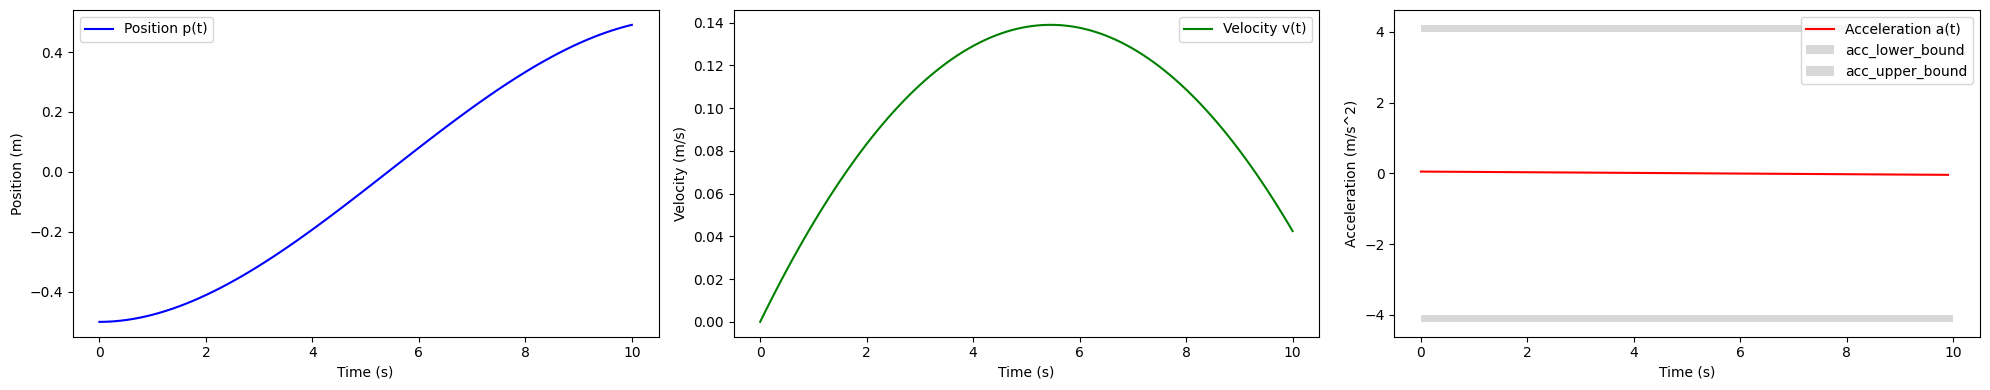

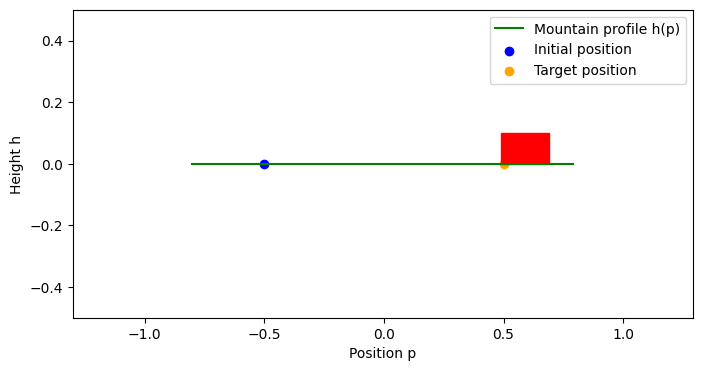

In [11]:
# Instantiate the simulator, and then run the simulation
simulator_dp = Simulator(dynamics, controller_dp, env, 1/freq, t_terminal)
simulator_dp.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_dp = Visualizer(simulator_dp)
visualizer_dp.display_plots()
visualizer_dp.display_animation()


----

#### **Part (d): Section review and specify your own task**

The procedure of uniquely defining a control task and specifing a controller to solve the task is shown as following. Based on this pipeline, you can also change several parameter (e.g. slope curve, initial state and target state) to create your own task and observe how it impact the controller's performance. Now it's time to play around it, have fun with your first controller implementation!

In [12]:
def setup_external(self) -> None:

    # Create symbolic states and inputs
    self.x_sym = [sp.Matrix(sp.symbols(f'p_{k} v_{k}')) for k in range(self.N + 1)]
    self.u_sym = [sp.Symbol(f'u_{k}') for k in range(self.N)]

    # Convert numpy weight matrices to sympy matrices
    self.Q_sym = sp.Matrix(self.Q)
    self.R_sym = sp.Float(self.R)
    self.Qf_sym = sp.Matrix(self.Qf)

    # Create symbolic reference state
    p_ref, v_ref = sp.symbols('p_ref v_ref')
    x_ref = [p_ref, v_ref]
    self.x_ref_sym = sp.Matrix(x_ref) 

    # Make a copy
    J, mu = self.J_sym, self.mu_sym

    # Terminal cost: J_N = (x_N - x_ref)^T Qf (x_N - x_ref)
    err_N = self.x_sym[self.N] - self.x_ref_sym
    J[self.N] = (err_N.T * self.Qf_sym * err_N)[0, 0]

    for k in reversed(range(self.N)):
        
        # x_{k+1} = A x_k + B u_k
        x_next = self.Ad * self.x_sym[k] + self.Bd * self.u_sym[k]

        # Cost at step k: u_k^T R u_k + J_{k+1}(x_{k+1})
        stage_cost = self.R_sym * self.u_sym[k]**2
        J_kplus1_sub = J[k + 1].subs({self.x_sym[k + 1][i]: x_next[i] for i in range(2)})

        total_cost = stage_cost + J_kplus1_sub

        # Evaluate cost for u_k = -1 and u_k = 1
        cost_minus1 = sp.simplify(total_cost.subs(self.u_sym[k], -1))
        cost_plus1  = sp.simplify(total_cost.subs(self.u_sym[k], 1))

        # Try subtracting to simplify the condition
        delta_cost = sp.simplify(cost_plus1 - cost_minus1)

        # Store optimal control policy as piecewise
        mu_k = sp.Piecewise(
            (-1, delta_cost > 0),
            (1,  True)  # fallback
        )
        #mu_k = sp.simplify(mu_k)

        # Store cost-to-go as piecewise
        J_k = sp.Piecewise(
            (cost_minus1, delta_cost > 0),
            (cost_plus1,  True)
        )
        #J_k = sp.simplify(J_k)

        # Store the symbolic expressions
        mu[k] = mu_k
        J[k] = J_k
        
    # Log the symbolic expressions back
    self.J_sym = J
    self.mu_sym = mu

    if self.verbose:
        print(f"Dynamic Programming policy with input constraints computed.")
        

In [13]:
# Bind the defined DP algorithm to the corresponding class, will be automatically called by constructor
DPController.setup = setup_external


# Define the profile of mountain h(p)
case_2 = 1 # 1, 2

# Define the initial / target state
initial_state_2 = np.array([-0.5, 0.0])
target_state_2 = np.array([0.5, 0.0])

# Instantiate class 'Env'
env_2 = Env(case_2, initial_state_2, target_state_2, h, symbolic_theta)

# Instantiate class 'Dynamics'
dynamics_2 = Dynamics(env_2, state_names, input_names, setup_dynamics)



# Define control frequency of controller and time length of simulation
freq_2 = 1
t_terminal_2 = 2 # time length of simulation
horizon_2 = freq_2 * t_terminal_2

# Define weight matrix in stage and terminal cost
Q_2 = np.diag([1, 1])
R_2 = np.array([[0.1]]) # smaller weight because the input need to be larger to balance the effect of gravity
Qf_2 = Q_2

# Instantiate the DP controller class
controller_dp_2 = DPController(env_2, dynamics_2, Q_2, R_2, Qf_2, freq_2, Horizon=horizon_2)

# Show the symbolic expression of the policies
controller_dp_2.print_solution()

u_0*(x_0) = Piecewise((-1, ITE(2.0*p_0 - 2.0*p_ref + 8.0*v_0 - 4.0*v_ref > 7.0, -6.0*p_0 + 6.0*p_ref - 16.0*v_0 + 4.0*v_ref + 7.0 < 0, ITE(2.0*p_0 - 2.0*p_ref + 8.0*v_0 - 4.0*v_ref > -7.0, 4.0*p_0 - 4.0*p_ref + 8.0*v_0 > 0, 6.0*p_0 - 6.0*p_ref + 16.0*v_0 - 4.0*v_ref + 7.0 > 0))), (1, True))
u_1*(x_1) = Piecewise((-1, 2.0*p_1 - 2.0*p_ref + 6.0*v_1 - 4.0*v_ref > 0), (1, True))


Simulation finished, will start plotting


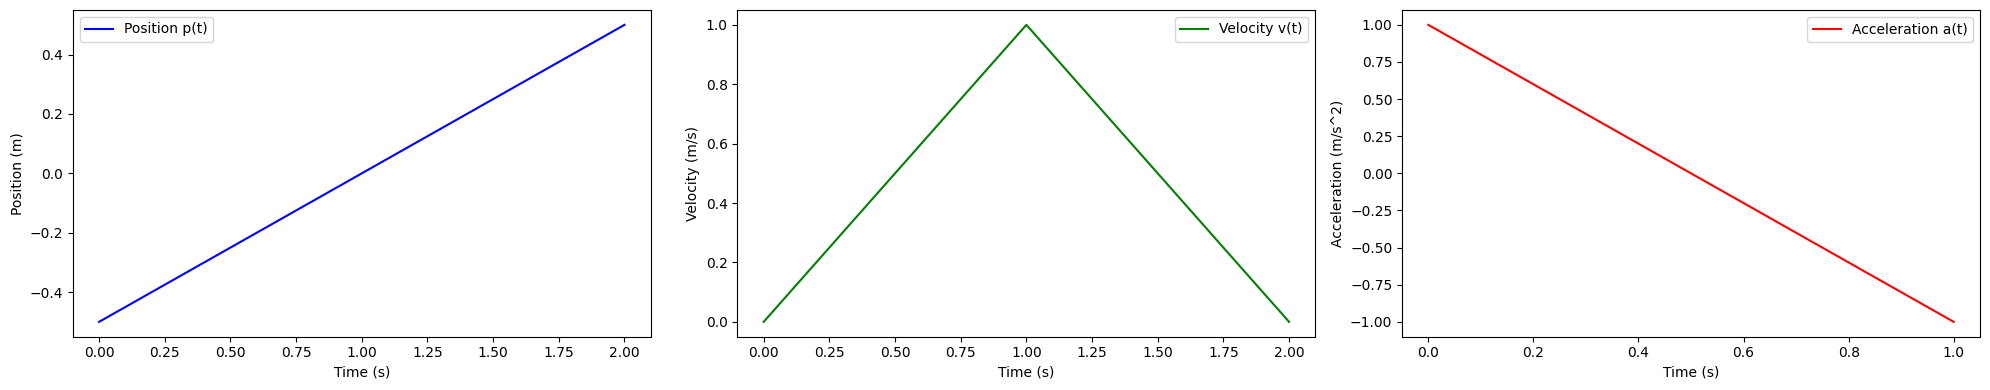

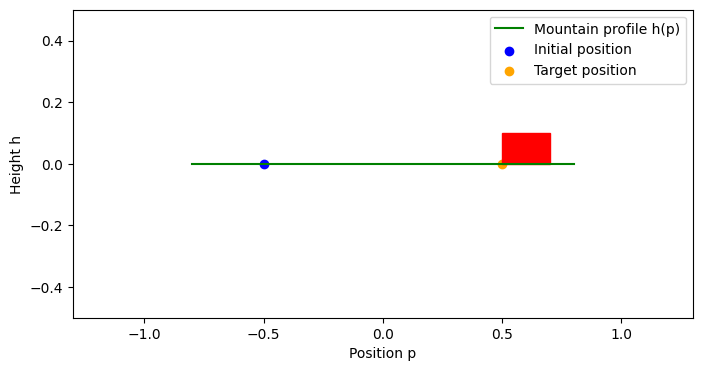

In [14]:
# Instantiate the simulator, and then run the simulation
simulator_dp_2 = Simulator(dynamics_2, controller_dp_2, env_2, 1/freq_2, t_terminal_2)
simulator_dp_2.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_dp_2 = Visualizer(simulator_dp_2)
visualizer_dp_2.display_plots()
visualizer_dp_2.display_animation()